In [2]:
import tensorflow_hub as hub
import json
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Sequential

In [3]:
with open('../../jiu_annotations.json', 'r') as file:
    annotations = json.load(file)

In [4]:
labels = {'standing': 0, 'takedown': 1, 'open_guard': 2, 'half_guard': 3, 'closed_guard': 4, '5050_guard': 5, 'side_control': 6, 'mount': 7, 'back': 8, 'turtle': 9}
num_labels = len(labels)
num_keypoints = 17
num_players = 2

In [ ]:
from random import shuffle

data = []

try:
    for annotation in annotations:
        label = annotation['position']
        if label[-1].isdigit():
            label = label[:-1]
        
        if annotation.get('pose1'):
            keypoints = annotation['pose1']
        else:
            keypoints = [[0] * 3] * num_keypoints
            
        if annotation.get('pose2'):
            keypoints += annotation['pose2']
        else:
            keypoints += [[0] * 3] * num_keypoints
            
        keypoints = np.array(keypoints).astype(np.float32).reshape(num_keypoints * 3 * num_players)
        
        max_x = max(keypoints)
        normalized_keypoints = keypoints / max_x
        
        data.append((normalized_keypoints, labels[label]))
    
except Exception as e:
    print("Error:", e)
    
keypoints_list = []
labels_list = []

shuffle(data)

for keypoints, label in data:
    keypoints_list.append(keypoints)
    labels_list.append(label)
    
labels_list = np.array(labels_list)

file.close()


In [13]:
TRAIN_PERCENTAGE = 0.8

train_keypoints = keypoints_list[:int(len(keypoints_list) * TRAIN_PERCENTAGE)]
train_labels = labels_list[:int(len(labels_list) * TRAIN_PERCENTAGE)]

test_keypoints = keypoints_list[int(len(keypoints_list) * TRAIN_PERCENTAGE):]
test_labels = labels_list[int(len(labels_list) * TRAIN_PERCENTAGE):]

train_keypoints = np.array(train_keypoints)
train_labels = tf.keras.utils.to_categorical(train_labels)

test_keypoints = np.array(test_keypoints)
test_labels = tf.keras.utils.to_categorical(test_labels)

print("Train: ", len(train_keypoints))
print("Test: ", len(test_keypoints))

Train:  96223
Test:  24056


In [14]:
model = Sequential([
    layers.Dense(512, activation='relu', input_shape=(num_keypoints * 3 * num_players,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_labels, activation='softmax')
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               52736     
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 127306 (497.29 KB)
Trainable params: 127306 (497.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
checkpoint_path = "weights.best.hdf5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

history = model.fit(train_keypoints, train_labels,
                    epochs=100,
                    batch_size=16,
                    validation_data=(test_keypoints, test_labels),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/100

5997/6014 [============================>.] - ETA: 0s - loss: 1.0553 - accuracy: 0.6282
Epoch 1: val_accuracy improved from -inf to 0.75200, saving model to weights.best.hdf5
6014/6014 [==============================] - 8s 1ms/step - loss: 1.0543 - accuracy: 0.6286 - val_loss: 0.6978 - val_accuracy: 0.7520
Epoch 2/100
 128/6014 [..............................] - ETA: 7s - loss: 0.7461 - accuracy: 0.7305

c:\Users\guilh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5996/6014 [============================>.] - ETA: 0s - loss: 0.6520 - accuracy: 0.7669
Epoch 2: val_accuracy improved from 0.75200 to 0.80150, saving model to weights.best.hdf5
6014/6014 [==============================] - 7s 1ms/step - loss: 0.6518 - accuracy: 0.7669 - val_loss: 0.5456 - val_accuracy: 0.8015
Epoch 3/100
5982/6014 [============================>.] - ETA: 0s - loss: 0.5286 - accuracy: 0.8125
Epoch 3: val_accuracy improved from 0.80150 to 0.82503, saving model to weights.best.hdf5
6014/6014 [==============================] - 7s 1ms/step - loss: 0.5280 - accuracy: 0.8127 - val_loss: 0.4835 - val_accuracy: 0.8250
Epoch 4/100
5968/6014 [============================>.] - ETA: 0s - loss: 0.4566 - accuracy: 0.8381
Epoch 4: val_accuracy did not improve from 0.82503
6014/6014 [==============================] - 7s 1ms/step - loss: 0.4567 - accuracy: 0.8381 - val_loss: 0.5758 - val_accuracy: 0.7951
Epoch 5/100
6006/6014 [============================>.] - ETA: 0s - loss: 0.4070 - acc

In [17]:
model.evaluate(test_keypoints, test_labels)

752/752 [==============================] - 1s 813us/step - loss: 0.1235 - accuracy: 0.9665


[0.12347672134637833, 0.9664948582649231]

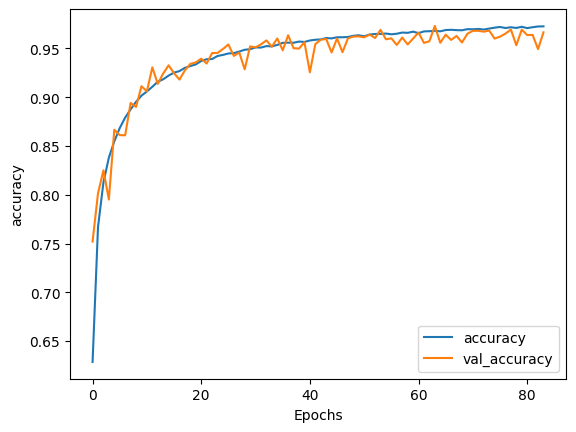

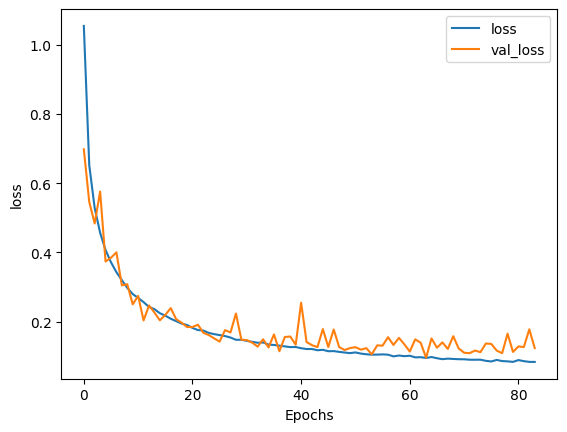

In [18]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [20]:
# REMOVE THIS LINE TO TEST THE MODEL
model_checkpoint = tf.keras.models.load_model(checkpoint_path)

model_new = tf.keras.models.load_model("jiu_model.h5")

keypoints = np.array(annotations[0]['pose2']).reshape(1, num_keypoints * 3)

max_x = max(keypoints[0])
normalized_keypoints = keypoints / max_x

prediction = model_new.predict(normalized_keypoints)

max_index = np.argmax(prediction[0])

for label, index in labels.items():
    if index == max_index:
        print(label)
        break

1/1 [==============================] - 0s 45ms/step
standing


In [21]:
# save model

model.save('jiu_model.h5')

c:\Users\guilh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
# Calculate accuracy for each label

test_dict = {}

n = len(test_keypoints)

print(n)

for i in range(0, n):
    test = np.array([test_keypoints[i]])

    prediction = model.predict(test)
    
    correct_label = np.argmax(test_labels[i])
    predicted_label = np.argmax(prediction)
    
    label_name = list(labels.keys())[predicted_label]
    
    if predicted_label == correct_label:
        if label_name in test_dict:
            test_dict[label_name]["correct"] += 1
        else:
            test_dict[label_name] = {"correct": 1, "incorrect": 0}
    else:
        if label_name in test_dict:
            test_dict[label_name]["incorrect"] += 1
        else:
            test_dict[label_name] = {"correct": 0, "incorrect": 1}
    
for key in test_dict:
    correct = test_dict[key]["correct"]
    incorrect = test_dict[key]["incorrect"]
    
    print(f"Accuracy for {key}: {correct / (correct + incorrect)}")


24056
1/1 [==============================] - 0s 20ms/step


KeyboardInterrupt: 